参考：https://www.salesanalytics.co.jp/datascience/datascience085/

https://www.salesanalytics.co.jp/datascience/datascience174/

In [7]:
# ライブラリーの読み込み
import pandas as pd
import numpy as np
from scipy import signal
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.style.use('ggplot') #グラフのスタイル
plt.rcParams['figure.figsize'] = [12, 9] # グラフサイズ設定

今回利用する時系列データのデータセットは、Airline Passengers（飛行機乗客数）は、Box and Jenkins (1976) の有名な時系列データです

In [2]:
# データセットの読み込み
url='https://www.salesanalytics.co.jp/591h' #データセットのあるURL
df=pd.read_csv(url,                      #読み込むデータのURL
            index_col='Month',        #変数「Month」をインデックスに設定
            parse_dates=True)         #インデックスを日付型に設定
df.head() #確認

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


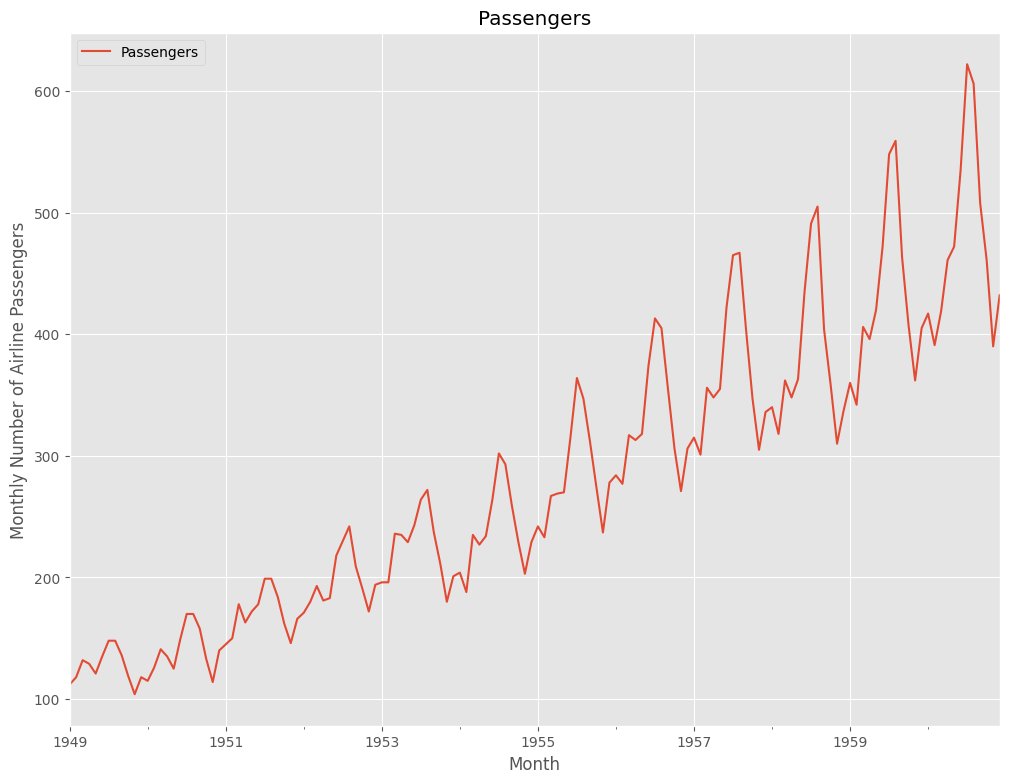

In [8]:
# プロット
df.plot()
plt.title('Passengers')                            #グラフタイトル
plt.ylabel('Monthly Number of Airline Passengers') #タテ軸のラベル
plt.xlabel('Month')                                #ヨコ軸のラベル
plt.show()

## 時系列データの変動成分の分解、以下の３成分に分解する

- トレンド成分
- 季節成分
- 残差成分

移動平均法（加法モデルを仮定）

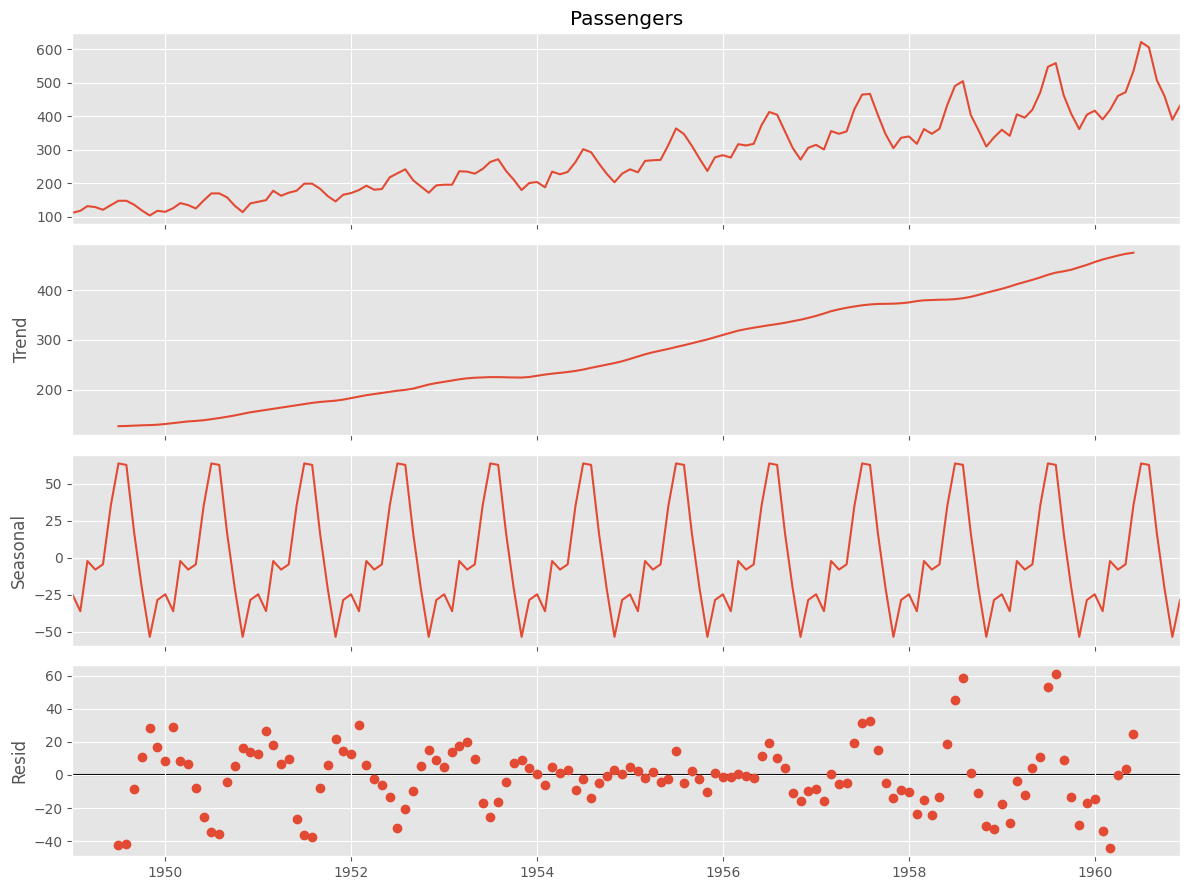

In [9]:
# 成分分解
result=seasonal_decompose(df.Passengers, model='additive', period=12)
# グラフ化
result.plot()
plt.show()

移動平均法（乗法モデルを仮定）

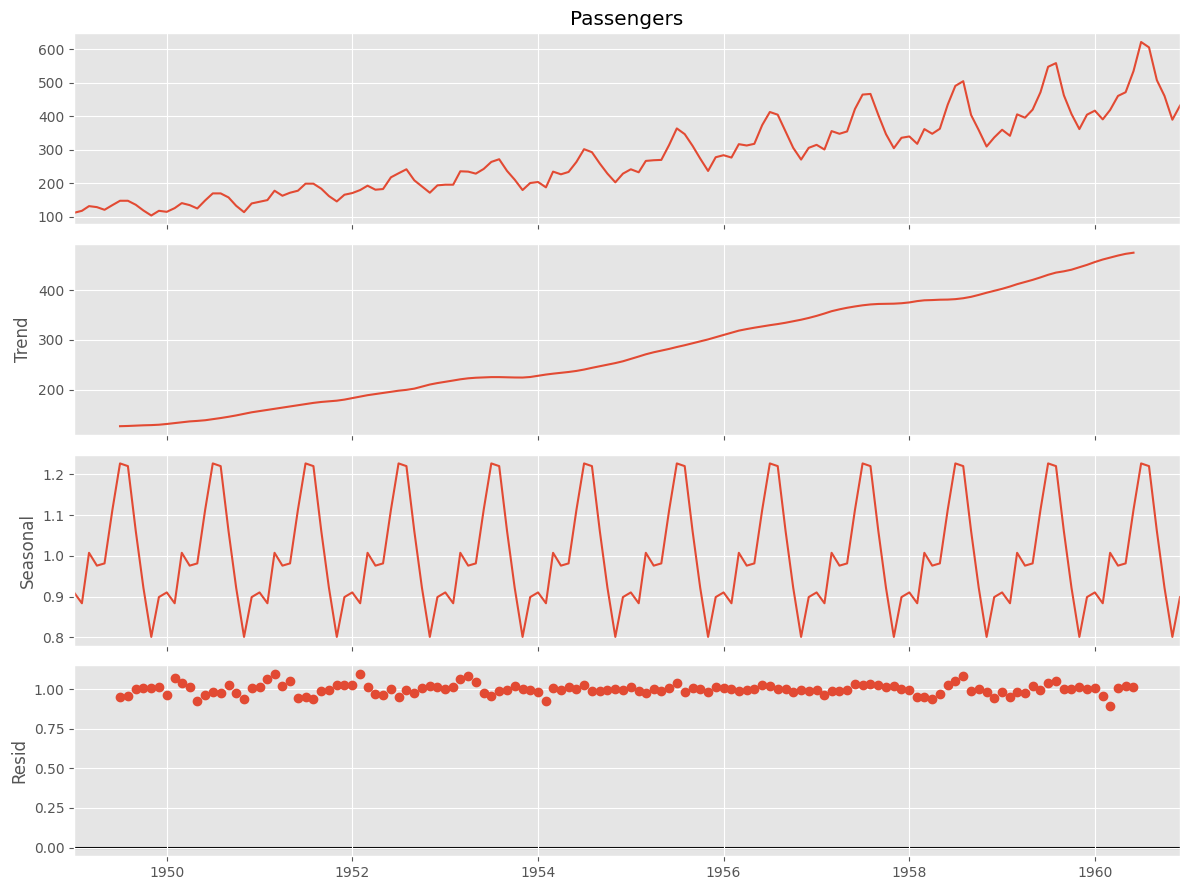

In [10]:
# 成分分解
result=seasonal_decompose(df.Passengers, model='multiplicative', period=12)
# グラフ化
result.plot()
plt.show()

STL分解（LOESS平滑化）

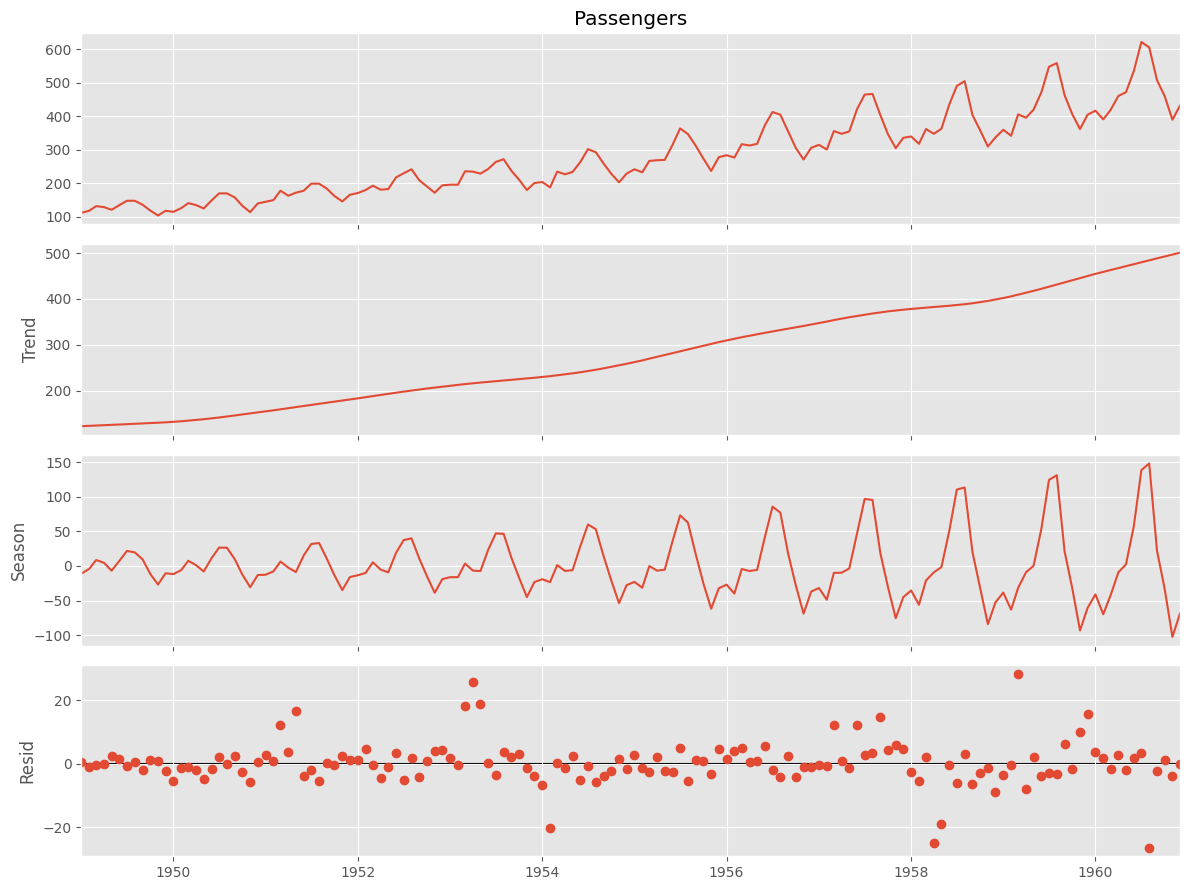

In [11]:
# 成分分解
stl=STL(df.Passengers, period=12, robust=True).fit()
# STL分解結果のグラフ化
stl.plot()
plt.show()

## 定常性の検定

拡張ディッキー・フラー検定（ADF検定） 
- 帰無仮説H0：時系列は非定常である（単位根を持つ） 
- 対立仮説H1：時系列は定常である（単位根を持たない）

In [12]:
# ADF検定（原系列）
dftest = adfuller(df.Passengers)
print('ADF Statistic: %f' % dftest[0])
print('p-value: %f' % dftest[1])
print('Critical values :')
for k, v in dftest[4].items():
    print('\t', k, v)

ADF Statistic: 0.815369
p-value: 0.991880
Critical values :
	 1% -3.4816817173418295
	 5% -2.8840418343195267
	 10% -2.578770059171598


ADF統計量（ADF Statistic）は0.815369で、p値（p-value）は0.991880ということで、1%有意でも5％有意でも10%有意でもありません。

次に、原系列を対数変換した対数系列に対するADF検定をします

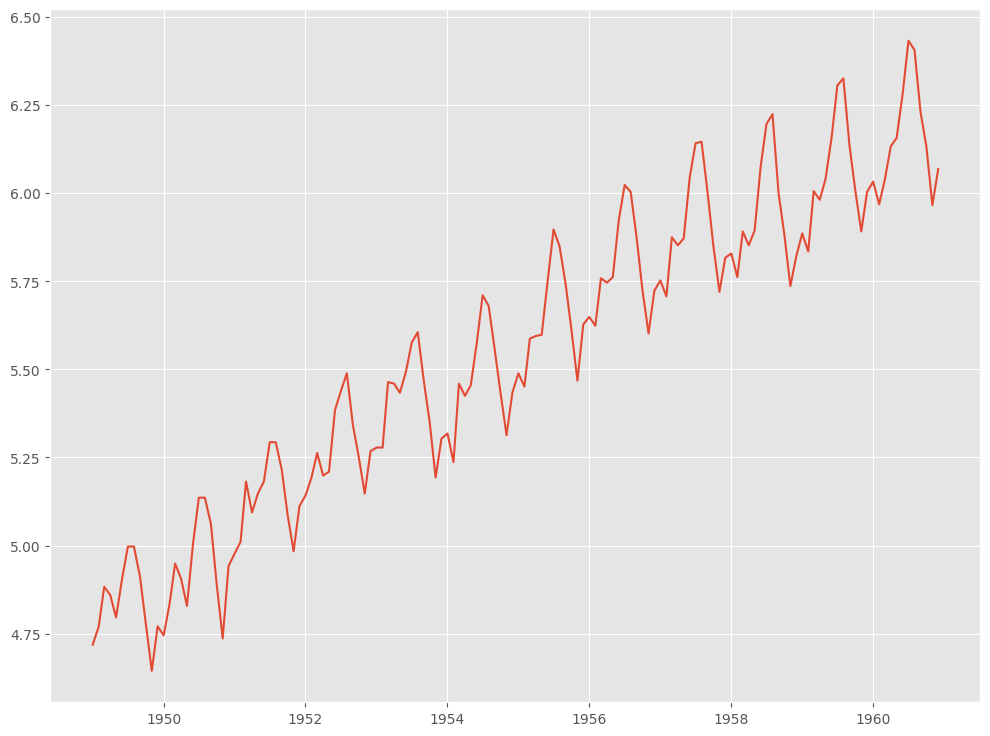

In [13]:
# 対数変換
df_log = np.log(df.Passengers)
plt.plot(df_log)

In [14]:
# ADF検定（対数系列）
dftest = adfuller(df_log)
print('ADF Statistic: %f' % dftest[0])
print('p-value: %f' % dftest[1])
print('Critical values :')
for k, v in dftest[4].items():
    print('\t', k, v)

ADF Statistic: -1.717017
p-value: 0.422367
Critical values :
	 1% -3.4816817173418295
	 5% -2.8840418343195267
	 10% -2.578770059171598


ADF統計量（ADF Statistic）は-1.717017で、p値（p-value）は0.422367ということで、帰無仮説（時系列は非定常である）は棄却できませんでした。

階差系列（次数１）を作ることで線型トレンドを除去します。

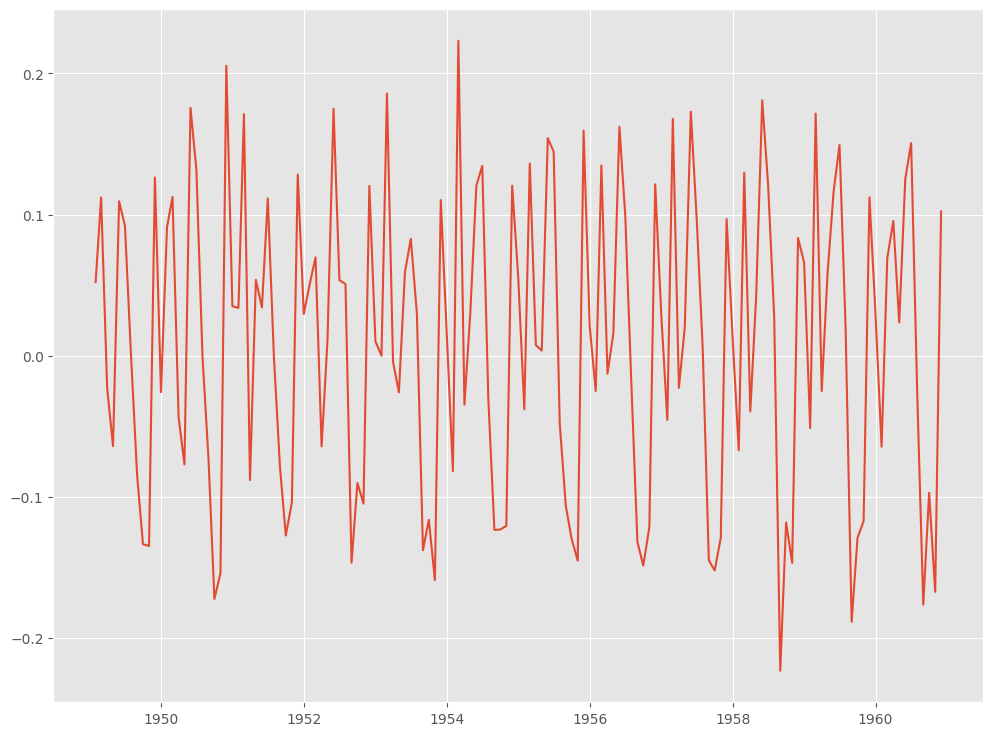

In [15]:
# 階差
df_log_diff1 = df_log.diff(1).dropna()
plt.plot(df_log_diff1)

In [16]:
# ADF検定
dftest = adfuller(df_log_diff1)
print('ADF Statistic: %f' % dftest[0])
print('p-value: %f' % dftest[1])
print('Critical values :')
for k, v in dftest[4].items():
    print('\t', k, v)

ADF Statistic: -2.717131
p-value: 0.071121
Critical values :
	 1% -3.4825006939887997
	 5% -2.884397984161377
	 10% -2.578960197753906


ADF統計量（ADF Statistic）は-2.717131で、p値（p-value）は0.071121ということで、帰無仮説（時系列は非定常である）を棄却できませんでした。

この階差系列（次数1）に対し、さらに季節階差（次数1）をとった時系列データを作ります。

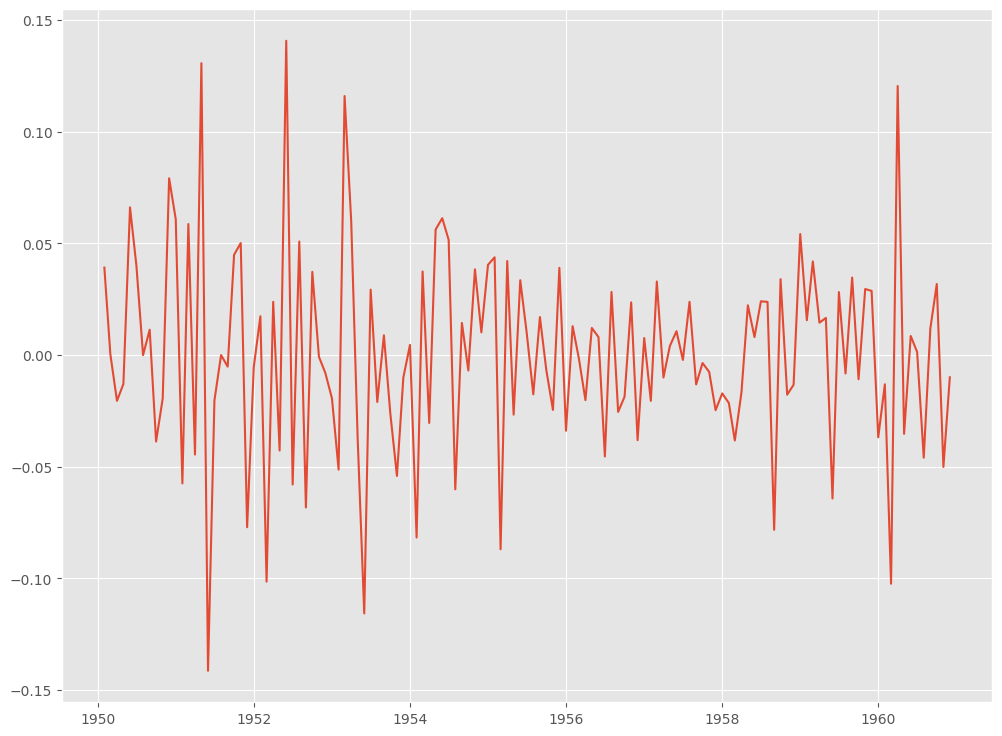

In [17]:
# 季節階差
df_log_diff1_diff12 = df_log_diff1.diff(12).dropna()
plt.plot(df_log_diff1_diff12)

In [18]:
# ADF検定
dftest = adfuller(df_log_diff1_diff12)
print('ADF Statistic: %f' % dftest[0])
print('p-value: %f' % dftest[1])
print('Critical values :')
for k, v in dftest[4].items():
    print('\t', k, v)

ADF Statistic: -4.443325
p-value: 0.000249
Critical values :
	 1% -3.4870216863700767
	 5% -2.8863625166643136
	 10% -2.580009026141913


ADF統計量（ADF Statistic）は-4.443325で、p値（p-value）は0.000249ということで、帰無仮説（時系列は非定常である）は棄却され対立仮説（時系列は定常である）が採択されます。